## Step 1: Import the necessary libraries:


In [45]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import itertools
import ast
import matplotlib.pyplot as plt 
import os

## Step 2: Define the environment:


In [46]:
devices_path = "./resources/devices.csv"
tasks_path = "./resources/tasks.csv"
dataFile = "./results/OnlyEnergyResults.csv"

#### ALL THE DEVICES


In [47]:
devices = pd.read_csv(devices_path)

devices["voltages_frequencies"] = devices["voltages_frequencies"].apply(lambda x: ast.literal_eval(x))
devices["capacitance"] = devices["capacitance"].apply(
    lambda x: ast.literal_eval(x)
)
devices["occupied_cores"] = devices["occupied_cores"].apply(
    lambda x: ast.literal_eval(x)
)
devices["powerIdle"] = devices["powerIdle"].apply(
    lambda x: ast.literal_eval(x)
)
devices["acceptableTasks"] = devices["acceptableTasks"].apply(
    lambda x: ast.literal_eval(x)
)
devices = devices.drop(["Unnamed: 0"],axis=1)
devices

,id,number_of_cpu_cores,occupied_cores,voltages_frequencies,ISL,capacitance,powerIdle,batteryLevel,errorRate,acceptableTasks,handleSafeTask
0,iot 0,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[(80000000.0, 4.0), (10000000.0, 1.8), (16000...",0.15,"[2.4928983413087824e-10, 2.925029147076276e-10...","[0.0009, 0.0009, 0.001, 0.001, 0.001, 0.0009, ...",3.800000e+10,0.01,"[3, 4, 2]",0
1,iot 1,8,"[0, 0, 0, 0, 0, 0, 0, 0]","[[(10000000.0, 1.8), (40000000.0, 2.7), (20000...",0.16,"[2.025958433654792e-10, 2.0241237749775673e-10...","[0.001, 0.001, 0.001, 0.0009, 0.0009, 0.0009, ...",3.700000e+10,0.01,"[1, 3, 2]",1
2,iot 2,4,"[0, 0, 0, 0]","[[(80000000.0, 4.0), (20000000.0, 2.3), (40000...",0.10,"[2.0703522189736892e-10, 2.541045071012014e-10...","[0.0007999999999999999, 0.001, 0.0007999999999...",3.600000e+10,0.03,"[3, 4, 1]",1
3,iot 3,8,"[0, 0, 0, 0, 0, 0, 0, 0]","[[(10000000.0, 1.8), (40000000.0, 2.7), (16000...",0.12,"[2.2325536185704405e-10, 2.0243182779502887e-1...","[0.0009, 0.0009, 0.0009, 0.0007999999999999999...",3.600000e+10,0.05,"[2, 3, 4, 1]",1
4,iot 4,8,"[0, 0, 0, 0, 0, 0, 0, 0]","[[(40000000.0, 2.7), (80000000.0, 4.0), (20000...",0.20,"[2.871170270860548e-10, 2.3479014270568305e-10...","[0.001, 0.001, 0.001, 0.001, 0.000799999999999...",3.600000e+10,0.03,"[2, 4, 1, 3]",1
...,...,...,...,...,...,...,...,...,...,...,...
146,mec 46,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[(600000000.0, 0.8), (1000000000.0, 1.0), (15...",0.00,"[1.6656868473928285e-09, 1.927477267954804e-09...","[0.65, 0.55, 0.75, 0.65, 0.55, 0.75, 0.75, 0.6...",1.000000e+02,0.08,"[4, 3, 2, 1]",0
147,mec 47,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[(750000000.0, 0.825), (600000000.0, 0.8), (1...",0.00,"[1.9774339762666487e-09, 1.7767494069440676e-0...","[0.65, 0.65, 0.65, 0.65, 0.65, 0.55, 0.75, 0.5...",1.000000e+02,0.09,"[4, 2, 1, 3]",1
148,mec 48,64,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[(750000000.0, 0.825), (1000000000.0, 1.0), (...",0.00,"[1.6989649489337003e-09, 1.833482809665926e-09...","[0.75, 0.75, 0.55, 0.65, 0.75, 0.55, 0.75, 0.6...",1.000000e+02,0.06,"[2, 3, 1, 4]",1
149,mec 49,32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[(750000000.0, 0.825), (600000000.0, 0.8), (1...",0.00,"[1.6408775978358996e-09, 1.896929720212431e-09...","[0.75, 0.75, 0.55, 0.55, 0.65, 0.75, 0.65, 0.5...",1.000000e+02,0.09,"[2, 3, 4]",1


### Step 2.2: Application


#### _ALL THE TASKS_


In [48]:
def read_tasks():
    tasks = pd.read_csv(tasks_path)
    tasks = tasks.sample(frac=1)
    tasks = tasks.set_index("id")
    tasks_copy = tasks.copy()
    tasks_copy = tasks_copy.drop(["job","dependency","mobility","status"],axis=1)
    taskList = tasks_copy.index.tolist()
    return taskList, tasks_copy

## Step 4 : DDT


### Step 4.1: Initializing The tree


In [49]:
class DDT(nn.Module):
    def __init__(self, num_input, num_output, depth, max_depth):
        super(DDT, self).__init__()
        self.depth = depth
        self.max_depth = max_depth
        if depth != max_depth:
            self.weights = nn.Parameter(torch.empty(num_input).normal_(mean=0, std=0.1))
            self.bias = nn.Parameter(torch.zeros(1))
            self.alpha = nn.Parameter(torch.zeros(1))
        if depth == max_depth:
            self.prob_dist = nn.Parameter(torch.zeros(num_output))
        if depth < max_depth:
            self.left = DDT(num_input, num_output, depth + 1, max_depth)
            self.right = DDT(num_input, num_output, depth + 1, max_depth)

    def forward(self, x):
        if self.depth == self.max_depth:
            return self.prob_dist
        val = torch.sigmoid(self.alpha * (torch.matmul(x, self.weights.t()) + self.bias))
        if val >= 0.5:
            return val * self.right(x)
        else:

            return (1 - val) * self.left(x)

## Step 5: RL


In [50]:
def calc_execution_time(device, task, core, dvfs):
    if device['id'] == "cloud":
        return task["computationalLoad"] / device["voltages_frequencies"][0]
    else:
        return task["computationalLoad"] / device["voltages_frequencies"][core][dvfs][0]


def calc_power_consumption(device, task, core, dvfs):
    if device['id'] == "cloud":return 13.85 
    return (device["capacitance"][core]* (device["voltages_frequencies"][core][dvfs][1] ** 2)* device["voltages_frequencies"][core][dvfs][0])
def calc_energy(device, task, core, dvfs):
    return calc_execution_time(device, task, core, dvfs) * calc_power_consumption(device, task, core, dvfs)


def calc_total(device, task, core, dvfs):
    timeTransMec = 0
    timeTransCC = 0
    baseTime = 0
    baseEnergy = 0
    totalEnergy = 0
    totalTime = 0

    transferRate5g =1e9
    latency5g=5e-3
    transferRateFiber =1e10
    latencyFiber=1e-3

    timeDownMec = task["returnDataSize"] / transferRate5g
    timeDownMec += latency5g
    timeUpMec = task["dataEntrySize"] / transferRate5g
    timeUpMec += latency5g

    alpha = 52e-5
    beta = 3.86412
    powerMec = alpha * 1e9 / 1e6 + beta

    timeDownCC = task["returnDataSize"] / transferRateFiber
    timeDownCC += latencyFiber
    timeUpCC = task["dataEntrySize"] / transferRateFiber
    timeUpCC += latencyFiber

    powerCC = 3.65 


    if device["id"].startswith("mec"):
        timeTransMec =  timeUpMec +  timeDownMec 
        energyTransMec = powerMec *  timeTransMec
        baseTime = calc_execution_time(device, task, core, dvfs)
        totalTime = baseTime + timeTransMec 
        baseEnergy = calc_energy(device, task, core, dvfs)
        totalEnergy =  baseEnergy + energyTransMec

    elif device['id'].startswith("cloud"):
        timeTransMec =  timeUpMec +  timeDownMec 
        energyTransMec = powerMec * timeTransMec
        
        timeTransCC = timeUpCC+timeDownCC
        energyTransCC =  powerCC * timeTransCC
        
        baseTime = calc_execution_time(device, task, core, dvfs)
        totalTime =  baseTime + timeTransMec +timeTransCC

        baseEnergy = calc_energy(device, task, core, dvfs)
        totalEnergy = baseEnergy + energyTransMec + energyTransCC

    elif device['id'].startswith("iot"):
        baseTime = calc_execution_time(device, task, core, dvfs)
        totalTime = baseTime
        baseEnergy = calc_energy(device, task, core, dvfs)
        totalEnergy = baseEnergy

    return totalTime , totalEnergy

In [51]:
def checkIfSuitable(state, device):
    safeFail = 0
    taskFail = 0
    if  state['safe'] and not device["handleSafeTask"]:
        safeFail = 1
    if state['kind'] not in device["acceptableTasks"]:
        taskFail = 1
    return taskFail,safeFail

In [52]:
def plot_histories(rSetup, punish, learning_mode, lossHistory, avg_time_history, avg_energy_history, avg_fail_history):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Create a grid of 2x2 for plots

    # Set a comprehensive title for the figure with dynamic parameters
    plt.suptitle(f"Training History with setup {rSetup}, punish: {punish}, mode: {learning_mode}", fontsize=16, fontweight='bold')

    # Plot for average loss history
    loss_values = [l.detach().numpy() if isinstance(l, torch.Tensor) else l for l in lossHistory]
    axs[0, 0].plot(loss_values, label='Average Loss', color='blue', marker='o')  # Add markers for clarity
    axs[0, 0].set_title('Average Loss History')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot for average time history
    time_values = np.array(avg_time_history)  # Ensure data is in numpy array
    axs[0, 1].plot(time_values, label='Average Time', color='red', marker='o')
    axs[0, 1].set_title('Average Time History')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Time')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot for average energy history
    energy_values = np.array(avg_energy_history)
    axs[1, 0].plot(energy_values, label='Average Energy', color='green', marker='o')
    axs[1, 0].set_title('Average Energy History')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Energy')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot for average fail history
    fail_values = np.array(avg_fail_history)
    axs[1, 1].plot(fail_values, label='Average Fail', color='purple', marker='o')
    axs[1, 1].set_title('Average Fail History')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Fail Count')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show() # Adjust layout to prevent overlap, leaving space for the title
    # plt.savefig(f"./../results/Only Energy Figs/r{rSetup}_p{punish}_m{learning_mode}")

In [53]:
def getSetup(e, t, setup, alpha=1, beta=1):
    match setup:
        case 1:
            return  -1 * (alpha * e + beta * t)
        case 2:
            return  -1 / (alpha * e + beta * t)
        case 3:
            return  -np.exp(alpha * e) - np.exp(beta * t)
        case 4:
            return  -np.exp(alpha * e + beta * t)
        case 5:
            return  np.exp(-1 * (alpha * e + beta * t))
        case 6:
            return  np.log(alpha * e + beta * t)
        case 7: 
            return  -((alpha * e + beta * t) ** 2)

def getPunish(punish):
    match punish:
        case 1:
            return 10
        case 2:
            return 100
        case 3:
            return  1000

In [54]:
class Environment:
    def __init__(self):
        self.learning_mode = 0
        self.rewardSetup = 1
        self.punishSetup = 1
        self.alpha = 1
        self.beta = 1

        self.taskList = []
        self.tasks_copy = None

        self.feature_size = 5
        self.num_actions = len(devices)
        self.max_depth = 3
        self.agent = DDT(self.feature_size, self.num_actions,depth=0, max_depth=self.max_depth)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=0.005)

        self.avg_time_history = np.array([])
        self.avg_energy_history = np.array([])
        self.avg_fail_history = np.array([0,0,0])
        self.avg_loss_history = np.array([])
        self.avg_reward_history = np.array([])
     
    def execute_action(self, state, action):
        self.taskList.pop(0)
        device = devices.iloc[action]        
        taskFail, safeFail = checkIfSuitable(state, device)
        
        if not (taskFail or safeFail):
            for coreIndex in range(len(device["occupied_cores"])):
                if device["occupied_cores"][coreIndex] == 0:
                    total_t, total_e  = calc_total(device, state, coreIndex,0)

                    reward = getSetup(total_t, total_e, self.rewardSetup, alpha=self.alpha, beta=self.beta)
                    return (reward,total_t,total_e,0,0)
                
        return (getPunish(self.punishSetup),0,0, taskFail,safeFail)


    def train(self, num_epoch, num_episodes):
        total_avg_t = 0
        total_avg_e = 0
        total_avg_r = 0
        total_avg_l = 0
        total_avg_fail = np.array([0,0,0],dtype=np.float64)
        
        for i in range(num_epoch):
            total_fail_epoch = np.array([0,0,0])
            total_reward_epoch = 0
            total_loss_epoch = 0
            total_time_epoch = 0
            total_energy_epoch = 0

            
            for j in range(num_episodes):
                state = self.tasks_copy.loc[self.taskList[0]]
                x = torch.tensor(np.array(state.values, dtype=np.float32)).unsqueeze(0)
                
                output = self.agent(x)
                action_probabilities = torch.softmax(output, dim=0)
                action_index = torch.multinomial(action_probabilities, 1).item()

                reward, t, e,taskFail,safeFail = self.execute_action(state, action_index)
                loss = (output[action_index] * reward)

                #single reward:
                if self.learning_mode == 0:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                total_reward_epoch += reward
                total_loss_epoch += loss
                total_time_epoch += t
                total_energy_epoch += e
                fails = np.array([taskFail + safeFail, taskFail, safeFail])
                total_fail_epoch += fails
                
            #total loss
            if self.learning_mode == 1:
                self.optimizer.zero_grad()
                total_loss_epoch.backward()
                self.optimizer.step()   
            
            avg_time = total_time_epoch / num_episodes
            avg_energy = total_energy_epoch / num_episodes
            avg_reward = total_reward_epoch / num_episodes
            avg_loss = total_loss_epoch/num_episodes
            avg_fail = [elem/num_episodes for elem in total_fail_epoch]


            #avg reward
            if self.learning_mode == 2:
                self.optimizer.zero_grad()
                avg_loss.backward()
                self.optimizer.step()
            
            
            self.avg_loss_history = np.append(self.avg_loss_history,avg_loss.detach().numpy())
            self.avg_reward_history = np.append(self.avg_reward_history,avg_reward)
            self.avg_time_history = np.append(self.avg_time_history,avg_time)
            self.avg_energy_history = np.append(self.avg_energy_history,avg_energy)
            self.avg_fail_history = np.vstack([self.avg_fail_history,avg_fail])



            total_avg_t += avg_time
            total_avg_e += avg_energy
            total_avg_l += avg_loss
            total_avg_r += avg_reward
            total_avg_fail += avg_fail
            
            

        avg_avg_t = total_avg_t / num_epoch
        avg_avg_l = total_avg_l / num_epoch
        avg_avg_r = total_avg_r / num_epoch
        avg_avg_e = total_avg_e / num_epoch



        half_num_epoch = num_epoch//2

        new_epoch_data = {
            "Setup": self.rewardSetup,
            "Learning Mode": self.learning_mode,
            "Punishment": self.punishSetup,
            "Alpha": self.alpha,
            "Beta": self.beta,

            # "is Loss min": 1 if self.last_epoch_l < min(self.lossHistory) else 0,
            "Task Converge": np.argmax(np.flip(self.avg_fail_history[:, 1])!= 0),
            "Task Fail Percentage": np.count_nonzero(self.avg_fail_history[:, 1])/len(self.avg_fail_history[:, 1]),
            "Safe Converge":np.argmax(np.flip(self.avg_fail_history[:, 2])!= 0),
            "Safe Fail Percentage": np.count_nonzero(self.avg_fail_history[:, 2])/len(self.avg_fail_history[:, 2]),
           
            "Average Time": avg_avg_t,
            "Last Epoch Time": self.avg_time_history[-1],
           
            "Average Energy": avg_avg_e,
            "Last Epoch Energy":  self.avg_energy_history[-1],
           
            "Average Reward": avg_avg_r,
            "Last Epoch Reward": self.avg_reward_history[-1],

            "Average Loss": avg_avg_l.detach(),
            "Last Epoch Loss": self.avg_loss_history[-1],

            "First 10 Avg Time": np.mean(self.avg_time_history[:10]),
            "Mid 10 Avg Time": np.mean(self.avg_time_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Time": np.mean(self.avg_time_history[:-10]),
            
            "First 10 Avg Energy":np.mean(self.avg_energy_history[:10]),
            "Mid 10 Avg Energy":np.mean(self.avg_energy_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Energy":np.mean(self.avg_energy_history[:-10]),  

            "First 10 Avg Reward":np.mean(self.avg_reward_history[:10]),
            "Mid 10 Avg Reward":np.mean(self.avg_reward_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Reward":np.mean(self.avg_reward_history[:-10]),


            "First 10 Avg Loss":np.mean(self.avg_loss_history[:10]),
            "Mid 10 Avg Loss":np.mean(self.avg_loss_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Loss":np.mean(self.avg_loss_history[:-10]),
            
            "First 10 (total, task, safe) Fail": np.mean(self.avg_fail_history[:10],axis=0),
            "Mid 10 (total, task, safe) Fail": np.mean(self.avg_fail_history[half_num_epoch:half_num_epoch + 10],axis=0),
            "Last 10 (total, task, safe) Fail":np.mean(self.avg_fail_history[:-10],axis=0),
        }   

        df = None
        if  os.path.exists(dataFile):
            df = pd.read_csv(dataFile)

            # Convert the new data into a DataFrame and concatenate it
            new_df = pd.DataFrame(new_epoch_data)
            df = pd.concat([df, new_df], ignore_index=True)

            # Save the updated DataFrame back to CSV
        else: 
            df = pd.DataFrame(new_epoch_data)

        df.to_csv(dataFile, index=False)

        plot_histories(self.rewardSetup,self.punishSetup,self.learning_mode,self.avg_loss_history,self.avg_time_history,self.avg_energy_history,self.avg_fail_history[:, 0])




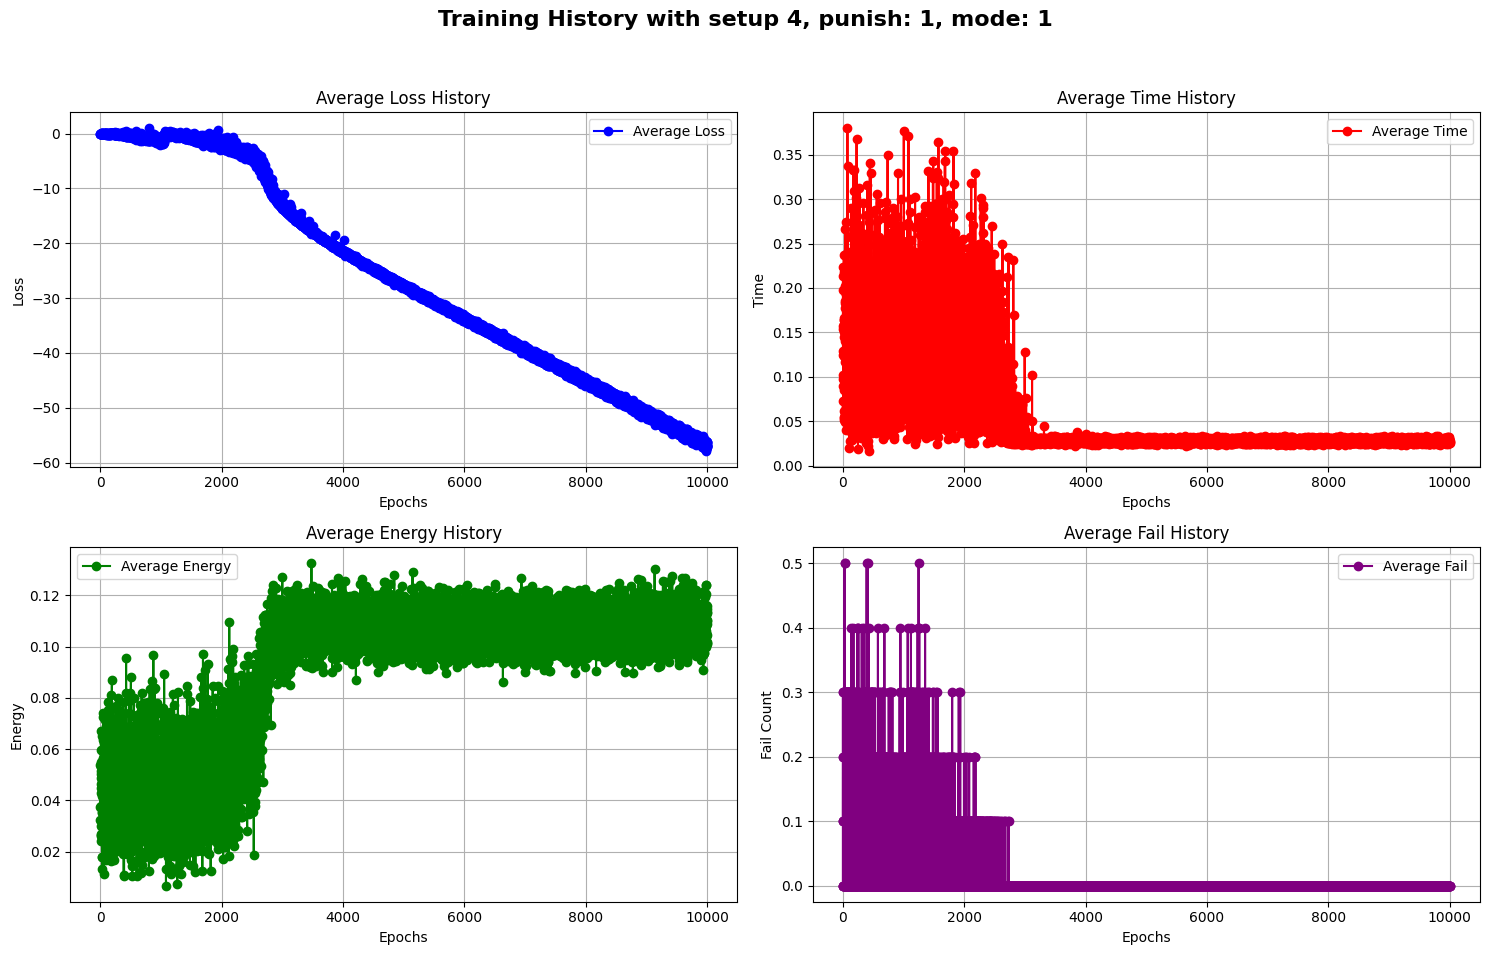

completed


In [55]:

def train_test(n):
    reward_setups = [1,4]
    punish_setups = [1]
    learningModes = [1]

    for i in range(n):
        for reward in reward_setups:
            for punish in punish_setups:
                    for mode in learningModes:
                        taskList, tasks_copy = read_tasks()
                        env = Environment()
                        env.learning_mode = mode
                        env.rewardSetup = reward
                        env.punishSetup = punish
                        env.taskList = taskList
                        env.tasks_copy = tasks_copy
                        
                        tree = env.agent
                        env.train(10001, 10)

train_test(1)   
print("completed")
